In [1]:
# load calibration matrix, ground-truth labels, and sample image
# detect objects in image using ground-truth labels or fine-tuned YOLOv8 model
# load point cloud
# downsample point cloud
# segment point cloud using RANSAC algorithm
# project points onto image plane
# extract frustums
# for each frustum:
    # cluster labels
    # generate 3d bounding boxes
    # visualize predictions
    # evaluate predictions

In [2]:
import cv2
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
import utils

import importlib
importlib.reload(utils)

<module 'utils' from '/home/tom/Documents/UNT/csce6260/projects/kitti-experiments/fusion/utils.py'>

### Load data

In [4]:
base = Path.home() / "kitti"
train_dir = base / "training"

train_img_dir = train_dir / "image_2"
kitti_images_train = sorted(train_img_dir.glob("*.png"))

train_labels_dir = train_dir / "label_2"
kitti_train_labels = sorted(train_labels_dir.glob("*.txt"))

velo_dir = train_dir / "velodyne"
point_cloud_train_files = sorted(velo_dir.glob("*.bin"))

calib_dir = train_dir / "calib"
calib_train_files = sorted(calib_dir.glob("*.txt"))

Sample Image Path: /home/tom/kitti/training/image_2/005902.png



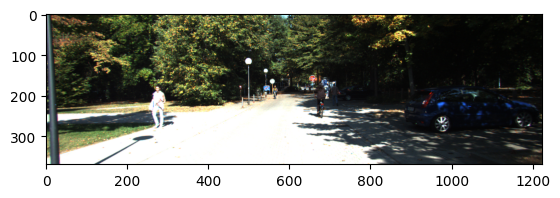

In [5]:
analysis_file_index = 5902
sample_image_path = kitti_images_train[analysis_file_index]
print(f"Sample Image Path: {sample_image_path}\n")
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

### Output ground-truth detections

In [6]:
sample_label = utils.parse_label_file(kitti_train_labels[analysis_file_index])
gt_detections = []
for label in sample_label:
    class_name = label["type"].lower()
    if class_name != "dontcare":
        x_min, y_min, x_max, y_max = label["bbox_2d"]
        gt_detections.append({
            "bounding_box": [x_min, y_min, x_max, y_max],
            "object_name": class_name.lower(),
            "confidence": float(1.0)
        })
gt_image = utils.draw_detection_output(sample_image_rgb, gt_detections, color_rgb=(0, 255, 0))
cv2.imwrite("gt_image.png", gt_image[:,:,::-1])
plt.imshow(gt_image);

Ground-truth objects and their metadata:
[{'type': 'Pedestrian', 'truncated': 0.0, 'occluded': 0, 'alpha': 1.99, 'bbox_2d': (251.71, 167.38, 305.35, 279.52), 'dimensions': (1.71, 0.64, 0.9), 'centroid': (-5.24, 1.52, 11.3), 'rotation_y': 1.57}, {'type': 'Cyclist', 'truncated': 0.0, 'occluded': 0, 'alpha': -1.67, 'bbox_2d': (658.44, 163.01, 695.76, 254.95), 'dimensions': (1.81, 0.58, 1.7), 'centroid': (1.46, 1.46, 14.82), 'rotation_y': -1.57}, {'type': 'Car', 'truncated': 0.03, 'occluded': 0, 'alpha': -0.53, 'bbox_2d': (870.66, 166.53, 1223.0, 278.43), 'dimensions': (1.31, 1.61, 3.78), 'centroid': (5.69, 1.16, 9.39), 'rotation_y': 0.0}, {'type': 'Cyclist', 'truncated': 0.0, 'occluded': 0, 'alpha': 1.68, 'bbox_2d': (554.84, 169.99, 570.8, 205.17), 'dimensions': (1.73, 0.61, 1.7), 'centroid': (-2.13, 1.21, 35.79), 'rotation_y': 1.62}, {'type': 'Pedestrian', 'truncated': 0.0, 'occluded': 0, 'alpha': -1.72, 'bbox_2d': (702.9, 165.48, 722.1, 225.64), 'dimensions': (1.82, 0.53, 0.88), 'centro